In [1]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

pd.set_option("max_columns",50)
pd.set_option("max_rows",30)
# json_ultimate = pd.read_json('C://Users/mattkelsey/Documents/ultimate_data_challenge.json', orient='records', lines=True)
# json_ultimate = pd.read_json('ultimate_data_challenge.json')
with open('ultimate_data_challenge.json') as f:
    data =  json.load(f)

user_data = pd.DataFrame(data)
mean_rating_bydriver = np.mean(user_data['avg_rating_by_driver'])
mean_rating_ofdriver = np.mean(user_data['avg_rating_of_driver'])
user_data.avg_rating_by_driver = user_data.avg_rating_by_driver.replace(np.nan,mean_rating_bydriver,regex=True)
user_data.avg_rating_of_driver = user_data.avg_rating_of_driver.replace(np.nan,mean_rating_ofdriver,regex=True)
user_data.phone.fillna(method='ffill',inplace=True)
user_data['active'] = user_data.last_trip_date > '2014-06-30'

In [2]:
from datetime import datetime
user_data['last_trip_date'] = pd.to_datetime(user_data['last_trip_date'])
last_date = datetime(2014,7,1)
user_data['days_since_last_trip'] = (last_date - user_data['last_trip_date']).dt.days

user_data.drop(['last_trip_date','signup_date'],axis=1,inplace=True)
user_data = pd.get_dummies(user_data)
from sklearn.preprocessing import LabelEncoder

le_ub = LabelEncoder()
user_data.ultimate_black_user = le_ub.fit_transform(user_data.ultimate_black_user)

le_active = LabelEncoder()
user_data.active = le_active.fit_transform(user_data.active)

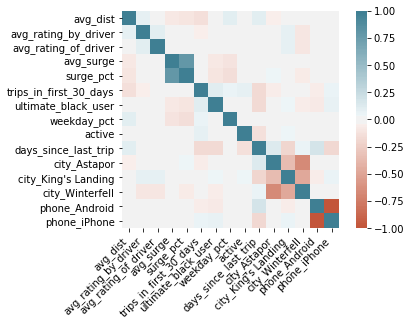

In [3]:
import seaborn as sns
corr = user_data.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [4]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [5]:
X = user_data.drop(['active','city_Winterfell','phone_iPhone'],axis=1)
y = user_data['active'].values
y = y.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3,random_state=42,stratify=y)
cv = RepeatedStratifiedKFold(n_splits=5,n_repeats=2,random_state=21)


In [6]:
def fit_model(X_train, y_train, model):
    '''Fits an ML model and then uses the .predict() method to generate predictions
    for the binary classification as well as associated probabilities and returns those 
    predictions in a tuple'''
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:,1]
    return (y_pred, y_pred_prob)

def roc_plot(y_test,y_pred_prob,title='ROC Curve'):
    '''Plots the ROC curve associated with classification probabilities
    generated from a ML model'''
    fpr,tpr,thresholds = roc_curve(y_test, y_pred_prob)
    plt.plot([0,1],[0,1],'k--',color='blue')
    plt.plot(fpr,tpr,label='ROC-AUC: %0.2f'%roc_auc_score(y_test, y_pred_prob))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend()
    plt.show()

def pr_plot(y_test,y_pred_prob,title='Precision Recall Curve'):
    '''Plots the ROC curve associated with classification probabilities
    generated from a ML model'''
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
    plt.plot([1,0],[0,1],'k--',color='red')
    plt.plot(recall,precision,label='PR AUC: %0.2f'%(auc(recall,precision)))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend()
    plt.show()
    

def model_stats(y_test,y_pred,y_pred_prob, model='Model'):
    '''Outputs summary statistics useful for comparing different ML models and their
    relative performance. Also outputs associated confusion matrix and classification report'''
    print("Tuned {} ROC-AUC score: {:0.2f}".format(model,roc_auc_score(y_test, y_pred_prob)))
    print("Tuned {} Precision Recall AUC score: {:0.2f}".format(model,average_precision_score(y_test, y_pred_prob)))
    print("Accuracy of tuned {}: {:0.2f}".format(model,accuracy_score(y_test, y_pred)))
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

def model_run_all(X_train,y_train,y_test,model,model_name='Model'):
    '''Combines ML process into one function by using calls to fit_model(), roc_plot(), pr_plot()
    and model_stats() to provide cohesive ML model analysis'''
    y_pred, y_pred_prob = fit_model(X_train,y_train,model)
    roc_plot(y_test,y_pred_prob,title="{} ROC Curve".format(model_name))
    pr_plot(y_test,y_pred_prob,title="{} Precision Recall Curve".format(model_name))
    model_stats(y_test, y_pred, y_pred_prob,model=model_name)
    return y_pred, y_pred_prob

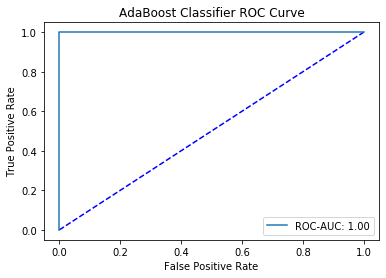

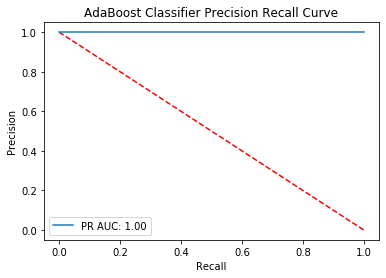

Tuned AdaBoost Classifier ROC-AUC score: 1.00
Tuned AdaBoost Classifier Precision Recall AUC score: 1.00
Accuracy of tuned AdaBoost Classifier: 1.00
[[14836     0]
 [    0   164]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14836
           1       1.00      1.00      1.00       164

    accuracy                           1.00     15000
   macro avg       1.00      1.00      1.00     15000
weighted avg       1.00      1.00      1.00     15000



In [7]:
ada = AdaBoostClassifier()
ada_pred, ada_pred_prob = model_run_all(X_train, y_train, y_test, ada, model_name='AdaBoost Classifier')

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


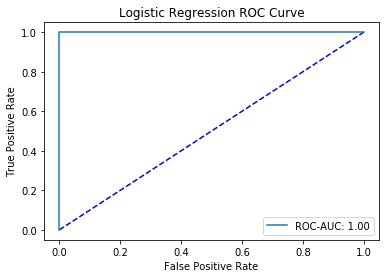

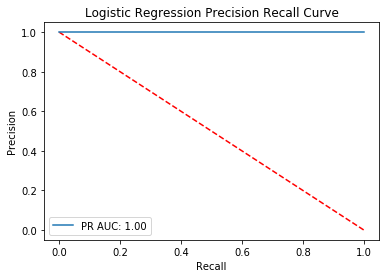

Tuned Logistic Regression ROC-AUC score: 1.00
Tuned Logistic Regression Precision Recall AUC score: 1.00
Accuracy of tuned Logistic Regression: 1.00
[[14836     0]
 [    0   164]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14836
           1       1.00      1.00      1.00       164

    accuracy                           1.00     15000
   macro avg       1.00      1.00      1.00     15000
weighted avg       1.00      1.00      1.00     15000



In [8]:
log_reg = LogisticRegression()
log_reg_pred, log_reg_pred_prob = model_run_all(X_train, y_train, y_test, log_reg, model_name='Logistic Regression')